In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
from sklearn.model_selection import KFold
from matplotlib import pyplot as plt

import torch
from torch import nn, optim
from torch.autograd import Variable

In [2]:
class ConcreteDropout(nn.Module):

    def __init__(self, layer, gpu_id, weight_regularizer=1e-6, dropout_regularizer=1e-5,
            init_min=0.05, init_max=0.5):
        super(ConcreteDropout, self).__init__()

        self.layer = layer
        self.weight_regularizer = weight_regularizer
        self.dropout_regularizer = dropout_regularizer

        init_min = np.log(init_min) - np.log(1. - init_min)
        init_max = np.log(init_max) - np.log(1. - init_max)
        self.p_logit = nn.Parameter(torch.Tensor(1))
        nn.init.uniform(self.p_logit, a=init_min, b=init_max)

        self.gpu_id = gpu_id

        self.use_dropout = True

    def forward(self, x):

        if self.use_dropout:
            return self.layer(self._concrete_dropout(x))

        return self.layer(x)

    def regularisation(self):
        """Computes weights and dropout regularisation for the layer, has to be
        extracted for each layer within the model and added to the total loss
        """

        if not self.use_dropout:
            return 0.0

        self.p = nn.functional.sigmoid(self.p_logit)
        
        weights_regularizer = self.weight_regularizer * self.sum_n_square() / (1 - self.p)
        dropout_regularizer = self.p * torch.log(self.p)
        dropout_regularizer += (1. - self.p) * torch.log(1. - self.p)
        dropout_regularizer *= self.dropout_regularizer*self.input_dim
        regularizer = weights_regularizer + dropout_regularizer
        return regularizer

    def _concrete_dropout(self, x):
        """Forward pass for dropout layer
        """
        eps = 1e-7
        temp = 0.1
        self.p = nn.functional.sigmoid(self.p_logit)
        
        self.input_dim = np.prod(x.size()[1:])

        uniform_distribution = torch.distributions.uniform.Uniform(0, 1)

        unif_noise = uniform_distribution.sample(sample_shape=x.size()[:2]).cuda(self.gpu_id)

        drop_prob = (torch.log(self.p + eps)
                    - torch.log(1 - self.p + eps)
                    + torch.log(unif_noise + eps)
                    - torch.log(1 - unif_noise + eps))
        drop_prob = nn.functional.sigmoid(drop_prob / temp)

        drop_prob = drop_prob.view(x.size())

        random_tensor = 1 - drop_prob
        retain_prob = 1 - self.p
        
        x  = torch.mul(x, random_tensor)
        
        x /= retain_prob
        return x

    def sum_n_square(self):
        """Helper function for paramater regularisation
        """
        sum_of_square = 0.0
        for param in self.layer.parameters():
            sum_of_square += torch.sum(torch.pow(param, 2))
        return sum_of_square

class Linear_relu(nn.Module):
    
    def __init__(self, inp, out):
        super(Linear_relu, self).__init__()
        self.model = nn.Sequential(nn.Linear(inp, out), nn.ReLU())
        
    def forward(self, x):
        return self.model(x)

class Model(nn.Module):
    
    def __init__(self, input_size, dropout_data):
        super(Model, self).__init__()

        nb_features = 50

        self.forward_main = nn.Sequential(
            ConcreteDropout(Linear_relu(input_size, nb_features),
                            dropout_data['gpu_id'],
                            weight_regularizer=dropout_data['wr'],
                            dropout_regularizer=dropout_data['dr']),
            ConcreteDropout(Linear_relu(nb_features, nb_features),
                            dropout_data['gpu_id'],
                            weight_regularizer=dropout_data['wr'],
                            dropout_regularizer=dropout_data['dr'])
        )

        self.forward_mean = ConcreteDropout(Linear_relu(nb_features, 1),
                                            dropout_data['gpu_id'],
                                            weight_regularizer=dropout_data['wr'],
                                            dropout_regularizer=dropout_data['dr'])

        self.log_prec = nn.Parameter(torch.FloatTensor([0]))

        self.log_prec_alpha = 0.1
        self.log_prec_beta = 0.01

    def forward(self, x):

        x = self.forward_main(x)
        mean = self.forward_mean(x)

        return mean

    def heteroscedastic_loss(self, true, mean):
        precision = torch.exp(self.log_prec)

        return torch.sum(precision * (true - mean)**2 - self.log_prec)/true.shape[0]

    def regularisation_loss(self):

        reg_loss = self.forward_main[0].regularisation() + \
                self.forward_main[1].regularisation()
        reg_loss += self.forward_mean.regularisation()

        reg_loss += -self.log_prec_beta*torch.exp(self.log_prec) + \
                (self.log_prec_alpha - 1)*self.log_prec
        
        return reg_loss

In [3]:
def train_model(train_X, train_y, val_X, val_y, dropout_data, epochs_count):
    
    gpu_id = dropout_data['gpu_id']

    batch_size = 200
    
    model = Model(train_X.shape[1], dropout_data).cuda(gpu_id)
    optimizer1 = optim.Adam(list(model.forward_main.parameters()) + \
                            list(model.forward_mean.parameters()))
    optimizer2 = optim.Adam([model.log_prec])
    optimizer3 = optim.Adam([model.forward_main[0].p_logit, model.forward_main[1].p_logit,
                            model.forward_mean.p_logit], lr=1e-1)

    train_losses = []
    val_losses = []

    for epoch_index in range(epochs_count):

        total_train_loss = 0.0

        model.train()

        train_permutation = np.random.permutation(len(train_X))

        train_batches_count = 0

        for optimizer in [optimizer1, optimizer2, optimizer3]:
            for batch_start in range(0, len(train_X), batch_size):

                batch_end = min(batch_start + batch_size, len(train_X))

                if batch_end == batch_start:
                    break

                batch_indices = train_permutation[batch_start:batch_end]
                batch_indices = np.random.choice(len(train_X), size=batch_size)

                batch_X = train_X[batch_indices]
                batch_y = train_y[batch_indices]

                batch_X = Variable(torch.FloatTensor(batch_X), requires_grad=False).cuda(gpu_id)
                batch_y = Variable(torch.FloatTensor(batch_y), requires_grad=False).cuda(gpu_id)

                mean = model.forward(batch_X)

                train_loss = model.heteroscedastic_loss(batch_y, mean)

                total_train_loss += float(train_loss)
                train_batches_count += 1

                reg_loss = model.regularisation_loss()

                optimizer.zero_grad()
                (train_loss + reg_loss).backward()
                optimizer.step()

        total_train_loss /= train_batches_count

        train_losses.append(total_train_loss)
        
        total_val_loss = 0.0

        model.eval()

        val_batches_count = 0
        
        for batch_start in range(0, len(val_X), batch_size):

            batch_end = min(batch_start + batch_size, len(val_X))

            if batch_end == batch_start:
                break

            batch_X = val_X[batch_start:batch_end]
            batch_y = val_y[batch_start:batch_end]

            batch_X = Variable(torch.FloatTensor(batch_X), requires_grad=False).cuda(gpu_id)
            batch_y = Variable(torch.FloatTensor(batch_y), requires_grad=False).cuda(gpu_id)

            mean = model.forward(batch_X)

            val_loss = model.heteroscedastic_loss(batch_y, mean)

            total_val_loss += float(val_loss)
            val_batches_count += 1

        total_val_loss /= val_batches_count

        val_losses.append(total_val_loss)
        
    return train_losses, val_losses, float(model.forward_main[0].p), \
            float(model.forward_main[1].p), float(model.forward_mean.p)

In [4]:
dropout_data = {'gpu_id': 1, 'wr': 1e-2, 'dr': 1e2}

In [5]:
def process_dataset(X, y, dataset_name, folds_count, epochs_count):

    k_fold = KFold(n_splits=folds_count, shuffle=True)

    probs1_per_split = []
    probs2_per_split = []
    probs3_per_split = []

    train_losses = None
    val_losses = None

    for train_indices, val_indices in k_fold.split(X):

        train_X = X[train_indices]
        train_y = y[train_indices]
        val_X = X[val_indices]
        val_y = y[val_indices]
        
        train_losses, val_losses, prob1, prob2, prob3 = train_model(train_X, train_y,
                val_X, val_y, dropout_data, epochs_count)

        probs1_per_split.append(prob1)
        probs2_per_split.append(prob2)
        probs3_per_split.append(prob3)

        print('done with split')

    plt.figure(figsize=(12, 4))
    
    plt.subplot(1, 2, 1)

    plt.plot(train_losses, label='train')
    plt.plot(val_losses, label='val')
    plt.legend()
    plt.xlabel('#epoch')
    plt.ylabel('-loglike')
    plt.title('{}: training curve'.format(dataset_name))

    plt.subplot(1, 2, 2)

    plt.plot(probs1_per_split, label='L=1')
    plt.plot(probs2_per_split, label='L=2')
    plt.plot(probs3_per_split, label='L=3')
    plt.legend()
    plt.xlabel('split ID')
    plt.ylabel('p')
    plt.title('{}: p over layers and splits'.format(dataset_name))

    plt.tight_layout()
    
    plt.show()

# Boston

/home/u0037/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: nn.init.uniform is now deprecated in favor of nn.init.uniform_.
  
/home/u0037/miniconda3/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


done with split
done with split
done with split
done with split
done with split
done with split
done with split
done with split
done with split
done with split


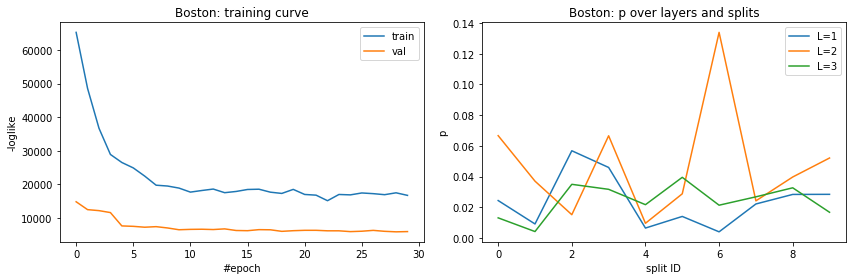

In [6]:
data = pd.read_csv('housing.data', delim_whitespace=True, header=None)
data = np.array(data)

X = data[:, :-1]
y = data[:, -1]

process_dataset(X, y, 'Boston', 10, 30)

# kin8nm

/home/u0037/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: nn.init.uniform is now deprecated in favor of nn.init.uniform_.
  


done with split
done with split
done with split
done with split
done with split


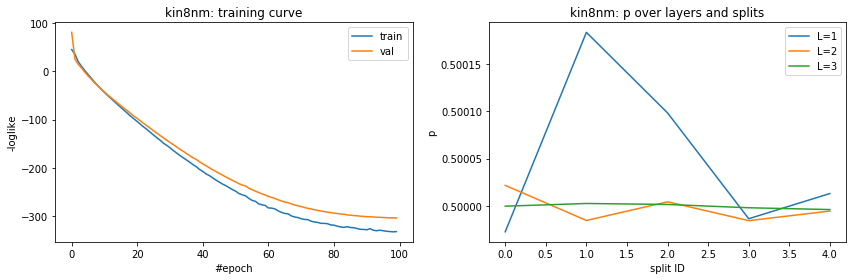

In [7]:
data = pd.read_csv('dataset_2175_kin8nm.arff')
data = np.array(data)

X = data[:, :-1]
y = data[:, -1]

process_dataset(X, y, 'kin8nm', 5, 100)

# Wine

/home/u0037/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: nn.init.uniform is now deprecated in favor of nn.init.uniform_.
  


done with split
done with split
done with split
done with split
done with split
done with split
done with split
done with split
done with split
done with split


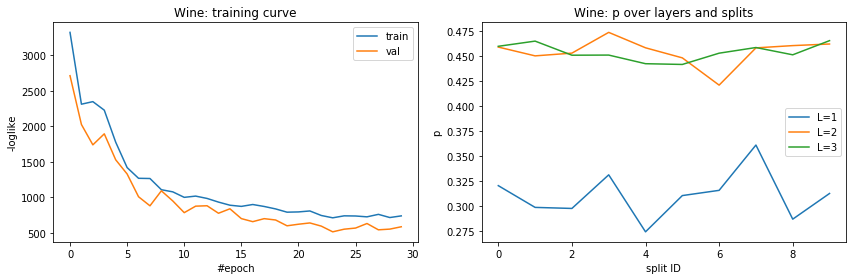

In [8]:
data = pd.read_csv('winequality-red.csv', delimiter=';')
data = np.array(data)

X = data[:, :-1]
y = data[:, -1]

process_dataset(X, y, 'Wine', 10, 30)